In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [47]:
df = pd.read_csv('netflix.csv')

In [48]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,23-05-2002,1.242857,1.145714,1.156429,1.196429,104790000,1.196429
1,24-05-2002,1.225000,1.197143,1.214286,1.210000,11104800,1.210000
2,28-05-2002,1.232143,1.157143,1.213571,1.157143,6609400,1.157143
3,29-05-2002,1.164286,1.085714,1.164286,1.103571,6757800,1.103571
4,30-05-2002,1.107857,1.071429,1.107857,1.071429,10154200,1.071429


In [49]:
close_prices = df['Close']

In [50]:
seq_len = 15

In [51]:
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(close_prices)[... , None]).squeeze()
scaled_price

array([0.0012894 , 0.00131064, 0.00122789, ..., 0.9886493 , 0.98991744,
       0.9811187 ])

In [60]:
X = [] # Data
y = [] # Target

for i in range(len(scaled_price) - seq_len):
  X.append(scaled_price[i : i + seq_len])
  y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]

train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * y.shape[0])]).float()

test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * y.shape[0]):]).float()

In [62]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    output, (hidden, cell) = self.lstm(x)
    return self.fc(hidden[-1, :])
model = Model(1, 96)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [64]:
num_epochs = 100

In [65]:
for epoch in range(num_epochs):
  output = model(train_x)
  loss = loss_fn(output, train_y)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0 and epoch != 0:
    print(epoch, "Epoch Loss", loss.detach().numpy())

10 Epoch Loss 0.005657165
20 Epoch Loss 0.0039899265
30 Epoch Loss 0.0035772715
40 Epoch Loss 0.0030042334
50 Epoch Loss 0.0018533122
60 Epoch Loss 9.9353616e-05
70 Epoch Loss 8.500943e-05
80 Epoch Loss 5.8102174e-05
90 Epoch Loss 4.6394543e-05


In [66]:
model.eval()
with torch.no_grad():
  output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

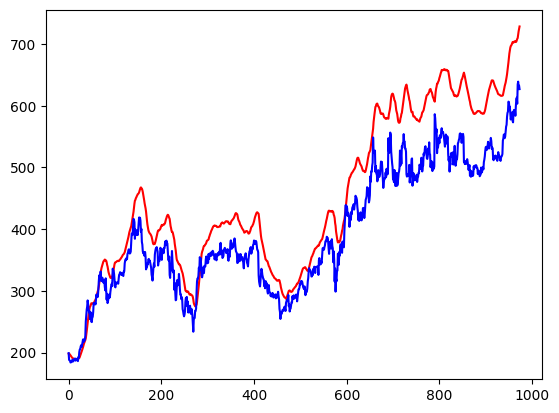

In [67]:
plt.plot(pred.squeeze(), color = 'Red', label = "Predicted Price")
plt.plot(real.squeeze(), color = 'Blue', label = "Real Price")
plt.show()